# Human Detection Project

## Índice:

- [Lectura de imágenes](#Lectura-de-imágenes)
    - [Fotos Train](#Fotos-Train)
    - [Fotos Test](#Fotos-Test)
- [Tratamiento de la imagenes Train](#Tratamiento-de-la-imagenes-Train)
    - [Recorte Fotos Train Negativa](#Recorte-Fotos-Train-Negativa)
    - [Ampliación del Rango Dinámico, Transformación de Intensidad y Suavizado](#Ampliación-del-Rango-Dinámico,-Transformación-de-Intensidad-y-Suavizado)
- [Extracción de Caracterísitcas](#Extracción-de-Caracterísitcas)
- [Entrenamiento del modelo](#Entrenamiento-del-modelo)
- [Slide Window](#Slide-Window)
- [Gaussian Pyramid](#Gaussian-Pyramid)
- [Supresión No Maximos](#Supresión-No-Maximos)
- [Prueba del Modelo](#Prueba-del-Modelo)






Autores:
- Jhonny Fabricio, Chicaiza Palomo https://github.com/jhonnyfc
- Hanwei, ke https://github.com/Sendaia
- David, Soto Arbizu https://github.com/Kirtasth


- Link del proyecto github: https://github.com/jhonnyfc/Human_Detection_Project

In [1]:
import numpy as np
import cv2
import os
import random
from skimage.feature import hog
from skimage import exposure
from sklearn import svm
from sklearn.decomposition import PCA
from skimage.transform import pyramid_gaussian
import matplotlib.pyplot as plt

# Lectura de imágenes

##### leerFotos:
- lee todas las fotos del directorio (Path) y las guarda en un diccionario.

In [2]:
def leerFotos(path,ini = 0):
    os.chdir(path)
    listaPos = os.listdir()
    fotosDic = {}
    
    for i in range(ini,len(listaPos)+ini):
        fotosDic[i] = cv2.imread(listaPos[i-ini],0)
    return fotosDic

### Fotos Tain

##### duplicaTrain:
- Crea imágenes espejo para tener más ejemplos de Train Positivas.

In [3]:
def duplicaTrain(fotos):
    indx = len(fotos)
    for i in range(len(fotos)):
        fotos[indx+i] = cv2.flip(fotos[i], 1)
        
    return fotos

In [4]:
dirPrincipal = os.path.abspath(os.getcwd())
path = dirPrincipal+'\\train_pos'
fotosPosTrain0 = leerFotos(path)
fotosPosTrain0 = duplicaTrain(fotosPosTrain0)

path = dirPrincipal+'\\train_neg'
fotosNegTrainSinTratar = leerFotos(path)

### Fotos Test

In [5]:
path =  dirPrincipal+'\\Test\\pos'
fotosTest0 = leerFotos(path)
path =  dirPrincipal+'\\Test\\neg'

fotosTest0.update(leerFotos(path,len(fotosTest0)))
os.chdir(dirPrincipal) 

# Tratamiento de la imagenes Train

##### generaImagenesRecortadas:

- Como el tamaño de las imágenes Train negativas no coincide con las Train positivas no podemos aplicar directamente HOG, por lo que vamos ha escoger aleatoriamente en cada imagen train negativa recortes de la misma dimension.


- **dataNeg**: diccionario con las fotos Train Negativas
- **winSize**: tamaño de la ventana ~> [alto,ancho]
- **numeroCortesxPh**: número de cortes por imagen

In [6]:
def generaImagenesRecortadas(dataNeg,winSize,numeroCortesxPh = 20):
    rowsFotoPersona = winSize[0]
    colsFotoPersona = winSize[1]
    
    fotosNegTrain = {}
    for i in range(len(dataNeg)):      
        rowsFotoEntorno = dataNeg[i].shape[0]
        colsFotoEntorno = dataNeg[i].shape[1]
        dimCol = colsFotoEntorno - colsFotoPersona
        dimRow = rowsFotoEntorno - rowsFotoPersona
        
        for j in range(numeroCortesxPh):
            print(dimCol,dimRow,i)
            randRow = random.randint(0,dimRow-1)
            randCol = random.randint(0,dimCol-1)
            randomImage = dataNeg[i][randRow:randRow + rowsFotoPersona ,randCol: randCol + colsFotoPersona]
            fotosNegTrain[j+numeroCortesxPh*i] = randomImage
            
    return fotosNegTrain

### Ampliación del Rango Dinámico, Transformación de Intensidad y Suavizado

Se ha decidido cambiar la dimension de las imagenes de train de 134x70 a 128x64 para recuperar más características

In [7]:
winSize = 128,64

In [8]:
def recortaTrainPos(fotosPos,winSize):
    x,y = fotosPos[0].shape
    
    for i in range(len(fotosPos)):
        incX = (x - winSize[0])//2
        incY = (y - winSize[1])//2    
        fotosPos[i] = fotosPos[i][incX:x-incX,incY:y-incY]
        
    return fotosPos

In [9]:
def ampRangoSet(fotos):
    fotSal = {}
    gamma = 0.35
    
    for i in range(len(fotos)):
        r1 = np.min(fotos[i])
        r2 = np.max(fotos[i])
        fotSal[i] = np.float32(fotos[i])
        fotSal[i] = 255*(fotSal[i]-r1)/(r2-r1)
        fotSal[i] = np.array(255*(fotSal[i] / 255) ** gamma, dtype = 'uint8')
        
    return fotSal

In [10]:
def trataFotos(fotos,kernelSize = 3):
    fotSal = {}
    ## Ampliación del rango
    fotSal = ampRangoSet(fotos)

    ## Suavizado
    n = kernelSize #tamaño del filtro
    sigma = 3 #desviación de la gaussiana
    mask = cv2.getGaussianKernel(n, sigma)*cv2.getGaussianKernel(n, sigma).T
    
    for i in range(len(fotSal)):
        fotSal[i] = cv2.filter2D(fotSal[i],-1,mask)
        
    return fotSal

In [11]:
## Tamaño del filtro de suavizado
dimFiltro = 5

fotosPosTrain0 = recortaTrainPos(fotosPosTrain0,winSize)
fotosPosTrain = trataFotos(fotosPosTrain0,dimFiltro)
fotosNegTrainTratadas = trataFotos(fotosNegTrainSinTratar,dimFiltro)
fotosNegTrain = generaImagenesRecortadas(fotosNegTrainTratadas,winSize)

fotosTest = trataFotos(fotosTest0,dimFiltro)

256 112 0
256 112 0
256 112 0
256 112 0
256 112 0
256 112 0
256 112 0
256 112 0
256 112 0
256 112 0
256 112 0
256 112 0
256 112 0
256 112 0
256 112 0
256 112 0
256 112 0
256 112 0
256 112 0
256 112 0
256 112 1
256 112 1
256 112 1
256 112 1
256 112 1
256 112 1
256 112 1
256 112 1
256 112 1
256 112 1
256 112 1
256 112 1
256 112 1
256 112 1
256 112 1
256 112 1
256 112 1
256 112 1
256 112 1
256 112 1
256 112 2
256 112 2
256 112 2
256 112 2
256 112 2
256 112 2
256 112 2
256 112 2
256 112 2
256 112 2
256 112 2
256 112 2
256 112 2
256 112 2
256 112 2
256 112 2
256 112 2
256 112 2
256 112 2
256 112 2
256 112 3
256 112 3
256 112 3
256 112 3
256 112 3
256 112 3
256 112 3
256 112 3
256 112 3
256 112 3
256 112 3
256 112 3
256 112 3
256 112 3
256 112 3
256 112 3
256 112 3
256 112 3
256 112 3
256 112 3
256 112 4
256 112 4
256 112 4
256 112 4
256 112 4
256 112 4
256 112 4
256 112 4
256 112 4
256 112 4
256 112 4
256 112 4
256 112 4
256 112 4
256 112 4
256 112 4
256 112 4
256 112 4
256 112 4
256 112 4


256 112 42
256 112 42
256 112 42
256 112 42
256 112 42
256 112 42
256 112 42
256 112 42
256 112 42
256 112 42
256 112 42
256 112 42
256 112 43
256 112 43
256 112 43
256 112 43
256 112 43
256 112 43
256 112 43
256 112 43
256 112 43
256 112 43
256 112 43
256 112 43
256 112 43
256 112 43
256 112 43
256 112 43
256 112 43
256 112 43
256 112 43
256 112 43
256 112 44
256 112 44
256 112 44
256 112 44
256 112 44
256 112 44
256 112 44
256 112 44
256 112 44
256 112 44
256 112 44
256 112 44
256 112 44
256 112 44
256 112 44
256 112 44
256 112 44
256 112 44
256 112 44
256 112 44
256 112 45
256 112 45
256 112 45
256 112 45
256 112 45
256 112 45
256 112 45
256 112 45
256 112 45
256 112 45
256 112 45
256 112 45
256 112 45
256 112 45
256 112 45
256 112 45
256 112 45
256 112 45
256 112 45
256 112 45
256 112 46
256 112 46
256 112 46
256 112 46
256 112 46
256 112 46
256 112 46
256 112 46
256 112 46
256 112 46
256 112 46
256 112 46
256 112 46
256 112 46
256 112 46
256 112 46
256 112 46
256 112 46
256 112 46

256 112 83
256 112 83
256 112 83
256 112 83
256 112 83
256 112 83
256 112 83
256 112 83
256 112 83
256 112 83
256 112 83
256 112 83
256 112 83
256 112 84
256 112 84
256 112 84
256 112 84
256 112 84
256 112 84
256 112 84
256 112 84
256 112 84
256 112 84
256 112 84
256 112 84
256 112 84
256 112 84
256 112 84
256 112 84
256 112 84
256 112 84
256 112 84
256 112 84
256 112 85
256 112 85
256 112 85
256 112 85
256 112 85
256 112 85
256 112 85
256 112 85
256 112 85
256 112 85
256 112 85
256 112 85
256 112 85
256 112 85
256 112 85
256 112 85
256 112 85
256 112 85
256 112 85
256 112 85
256 112 86
256 112 86
256 112 86
256 112 86
256 112 86
256 112 86
256 112 86
256 112 86
256 112 86
256 112 86
256 112 86
256 112 86
256 112 86
256 112 86
256 112 86
256 112 86
256 112 86
256 112 86
256 112 86
256 112 86
256 112 87
256 112 87
256 112 87
256 112 87
256 112 87
256 112 87
256 112 87
256 112 87
256 112 87
256 112 87
256 112 87
256 112 87
256 112 87
256 112 87
256 112 87
256 112 87
256 112 87
256 112 87

256 112 126
256 112 127
256 112 127
256 112 127
256 112 127
256 112 127
256 112 127
256 112 127
256 112 127
256 112 127
256 112 127
256 112 127
256 112 127
256 112 127
256 112 127
256 112 127
256 112 127
256 112 127
256 112 127
256 112 127
256 112 127
256 112 128
256 112 128
256 112 128
256 112 128
256 112 128
256 112 128
256 112 128
256 112 128
256 112 128
256 112 128
256 112 128
256 112 128
256 112 128
256 112 128
256 112 128
256 112 128
256 112 128
256 112 128
256 112 128
256 112 128
256 112 129
256 112 129
256 112 129
256 112 129
256 112 129
256 112 129
256 112 129
256 112 129
256 112 129
256 112 129
256 112 129
256 112 129
256 112 129
256 112 129
256 112 129
256 112 129
256 112 129
256 112 129
256 112 129
256 112 129
256 112 130
256 112 130
256 112 130
256 112 130
256 112 130
256 112 130
256 112 130
256 112 130
256 112 130
256 112 130
256 112 130
256 112 130
256 112 130
256 112 130
256 112 130
256 112 130
256 112 130
256 112 130
256 112 130
256 112 130
256 112 131
256 112 131
256 

256 112 170
256 112 170
256 112 170
256 112 170
256 112 170
256 112 170
256 112 170
256 112 170
256 112 170
256 112 170
256 112 171
256 112 171
256 112 171
256 112 171
256 112 171
256 112 171
256 112 171
256 112 171
256 112 171
256 112 171
256 112 171
256 112 171
256 112 171
256 112 171
256 112 171
256 112 171
256 112 171
256 112 171
256 112 171
256 112 171
256 112 172
256 112 172
256 112 172
256 112 172
256 112 172
256 112 172
256 112 172
256 112 172
256 112 172
256 112 172
256 112 172
256 112 172
256 112 172
256 112 172
256 112 172
256 112 172
256 112 172
256 112 172
256 112 172
256 112 172
256 112 173
256 112 173
256 112 173
256 112 173
256 112 173
256 112 173
256 112 173
256 112 173
256 112 173
256 112 173
256 112 173
256 112 173
256 112 173
256 112 173
256 112 173
256 112 173
256 112 173
256 112 173
256 112 173
256 112 173
256 112 174
256 112 174
256 112 174
256 112 174
256 112 174
256 112 174
256 112 174
256 112 174
256 112 174
256 112 174
256 112 174
256 112 174
256 112 174
256 

# Extracción de Caracterísitcas

## Hog (Histogram of Oriented Gradients)
HOG es un extractor de características de las imágens que se basa en el conteo de las orientaciones del gradiente. El algoritmo divide una imagen en bloques, realiza el conteo de las orientaciones y las fusiona por agrupaciones de bloques. 

Los parámetros de entrada son:
* **orientations**: número de orientaciones.
* **pixels_per_cell**: tamaño de la celda.
* **cells_per_block**: número de celdas por cada bloque.
* **block_norm**: método de normalización de bloques:
    * L1:
       Normalization using L1-norm.
    * L1-sqrt:
       Normalization using L1-norm, followed by square root.
    * L2:
       Normalization using L2-norm.
    * L2-Hys:
       Normalization using L2-norm, followed by limiting the
       maximum values to 0.2 (`Hys` stands for `hysteresis`) and
       renormalization using L2-norm. (default)
* **visualize**: True/False devuelve la imagen procesada en la salida.
* **visualise**: True/False
* **transform_sqrt**: aplica la compresión de la ley potencial para normalizar la imagen antes del procesamiento.
* **feature_vector**: devolver los datos como un vector.

Mas info de la función en los siguintes link:
- https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog
- https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

Los parametros de entrada seleccionados son:

In [12]:
orientations    = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
block_norm      = 'L2' 
visualize       = False
visualise       = None
transform_sqrt  = True
feature_vector  = True

 ##### featuresExtrac:
 - Extracción de las Caractrisiticas.
 
 
 - **imagenes**: diccionario con las imágenes a tratar.
 - **esPositivo**: 1 si es clase positiva, 0 en caso contrario.

In [13]:
def featuresExtrac(imagenes,esPositivo):    
    ## Tamaño del vector
    auxDim = hog(imagenes[0],orientations,pixels_per_cell,cells_per_block,block_norm,visualize,visualise,transform_sqrt,feature_vector)
    tamHog = len(auxDim)
    
    #inicializamos la matriz que guarda los imagenes vectolizados
    fdImagenesHog = np.zeros((len(imagenes),tamHog))
    
    for i in range(len(imagenes)):
        fdImagenesHog[i,:] = hog(imagenes[i],orientations,pixels_per_cell,cells_per_block,block_norm,visualize,visualise,transform_sqrt,feature_vector)
        
    #asignamos el vector de clases(y) 
    if esPositivo:
        y = np.ones((len(imagenes),1))
    else:
        y = np.zeros((len(imagenes),1))

    return fdImagenesHog,y

In [14]:
fdPosTrainHog,yPos = featuresExtrac(fotosPosTrain,1)

In [15]:
fdNegTrainHog,yNeg = featuresExtrac(fotosNegTrain,0)

In [16]:
fdTrainHog = np.vstack((fdPosTrainHog,fdNegTrainHog))
y = np.vstack((yPos,yNeg))

# Entrenamiento del modelo

## SVM (Support Vector Machine)

SVM es un algoritmo de aprendizaje supervisado que resuelve problemas de clasificación y regresión. Dado un conjunto de ejemplos de entrenamiento (Train) podemos etiquetar las clases y entrenar una SVM para construir un modelo que prediga la clase de una nueva muestra.

More info:

- https://scikit-learn.org/stable/modules/svm.html

Se ha decidido utilizar kernel lineal debido a que ya tenemos suficientes características

In [17]:
clfHog = svm.LinearSVC(C=0.01)
clfHog.fit(fdTrainHog[:,:],y[:,:].ravel())

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

#### Precisión con los conjuntos de train

In [18]:
clfHog.score(fdPosTrainHog,yPos)

0.9920071047957372

In [19]:
clfHog.score(fdNegTrainHog,yNeg)

0.9990049751243781

# Slide Window

##### slidWindow:
- Extrae ventanes de las imágenes para su estudio.


- **winSize**: tamaño de la ventana ~> [alto,ancho].
- **step**: paso del desplazamiento de la ventana en la imagen.

In [20]:
def slidWindow(imagen, winSize,step = 10):
    arrayImagen = []
    
    for i in range(0,imagen.shape[0]- winSize[0],step):        
        for j in range(0,imagen.shape[1]- winSize[1],step):
            arrayImagen.append((i,j,imagen[i:i+ winSize[0], j:j + winSize[1]]))
    
    return arrayImagen

# Gaussian Pyramid

##### estudiaFoto:
- Realiza la piramide gaussian de la imagen de entrada y aplica a cada nivel la funcion ventana deslizante.


- **im**: array de la imagen a estudiar.
- **winSize**: tamaño de la ventana ~> [alto,ancho].
- **clfHog**: clasificador SVM entrenado.
- **ratio**: factor de escalado de la piramide Gaussiana

In [21]:
def estudiaFoto(im,winSize,clfHog,ratio = 2):#Ratio de reducción
    # List to store the detections
    hdetections = []
    detectJump = 0;
    
    for scaLev,imScaled in enumerate(pyramid_gaussian(im,downscale=ratio,multichannel=False)):
        if (imScaled.shape[0] >= winSize[0] and imScaled.shape[1] >= winSize[1]):
            for (x,y,imVentana) in slidWindow(imScaled,winSize):
                if (detectJump <= 0):
                    fdHog = hog(imVentana,orientations,pixels_per_cell,cells_per_block,block_norm,visualize,visualise,transform_sqrt,feature_vector);
                    predHog = clfHog.predict(fdHog.reshape(1,-1))
                    acc = clfHog.decision_function(fdHog.reshape(1,-1))[0]
                    
                    if (predHog == 1):
                        hdetections.append((int(x*(ratio**scaLev)),int(y*(ratio**scaLev)),int(winSize[1]*(ratio**scaLev)),int(winSize[0]*(ratio**scaLev)),acc ))
                detectJump -= 1;
    return hdetections

# Supresión No Maximos

### Funcion de Solapamiento
##### overlappingArea:
- Calcula el area que comparten las dos secciones (rectangulos) de entrada


- **detection_x**: tupla de las coordenadas de la ventana, es la salida de la funcion **estudiaFoto**.

In [22]:
def overlappingArea(detection_1, detection_2):
    ## Calculo de las coordenadas X Y de la detecciones
    x1_tl,y1_tl,w1,h1,_ = detection_1
    
    x1_br = x1_tl + h1
    y1_br = y1_tl + w1
    
    x2_tl,y2_tl,w2,h2,_ = detection_2
    
    x2_br = x2_tl + h2
    y2_br = y2_tl + w2
    
    
    ## Calculate the overlapping Area
    x_overlap = max(0, min(x1_br, x2_br) - max(x1_tl, x2_tl) )
    y_overlap = max(0, min(y1_br, y2_br) - max(y1_tl, y2_tl) )
    
    overlap_area = x_overlap * y_overlap
    area_1 = w1 * h1
    area_2 = w2 * h2
    total_area = area_1 + area_2 - overlap_area
    
    return overlap_area / float(total_area)

  ##### SNoM:
  - Elimina las predicciones que se solapan dejando solo una de ellas.
  
  
  - **detections**: lista con las coordenadas de las ventanas, es la salida de la funcion **estudiaFoto**.

In [23]:
def SNoM(detections, umbral  = 0):
    esVacio = not detections
    if (esVacio == True):
        return []
    
    GoodDetec = []
    
    ## Ordenamos las deteciones por coefiente de precision
    detections = sorted(detections, key=lambda detections: detections[4],reverse=True)
    
    GoodDetec.append(detections[0])
    del detections[0]
    
    while esVacio == False:
        for gDetec in GoodDetec:
            if overlappingArea(detections[0], gDetec) > umbral:
                del detections[0]
                break
        else:
            GoodDetec.append(detections[0])
            del detections[0]
        esVacio = not detections

    return GoodDetec

# Prueba del Modelo

- **En diccionario fotosTest los 50 primeros elemtos son postivos y los 10 ultimos negativos.**

  ##### showImg:
  - muestra  la imagne que se le pasa com argumento, se ha realizado para ahorrar codigo.

In [31]:
def showImg(im,text = 'xd'):
    plt.figure(figsize=(7,7))
    plt.title(text)
    plt.imshow(im, cmap = 'gray' )

  ##### muestraResultado:
  
  - Crea los rectangulos que se han detectado con clase positiva
  
  
  - **detections**: lista con las coordenadas de las ventanas detectadas.
  - **im0**: imagen que se ha estudiado.
  - **text**: texto complementario.

In [25]:
def muestraResultado(detections,im0, text = "Pedestrains Detected"):
    esVacio = not detections
    if (esVacio == False):
        color = (255)
        im = im0.copy()
        print('Se han detectado',len(detections),'personas en la imagen')
        for (x, y,w, h,_) in detections:
                # Draw the detections
                cv2.rectangle(im, (y, x), (y+w, x+h), color, thickness=2)
        showImg(im,text)
    else:
        showImg(im0,'Don\'t have Pedestrains')

In [26]:
%%time
num = 35
humanDetec = estudiaFoto(fotosTest[num],winSize,clfHog,ratio=2)

Wall time: 9.35 s


### Antes de la supresion de no maximos

Se han detectado 57 personas en la imagen


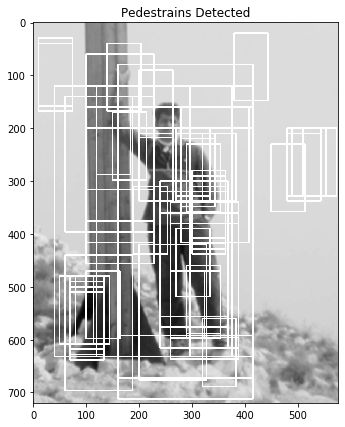

In [27]:
muestraResultado(humanDetec,fotosTest[num])

### Despues de la supresion de no maximos

Se han detectado 5 personas en la imagen


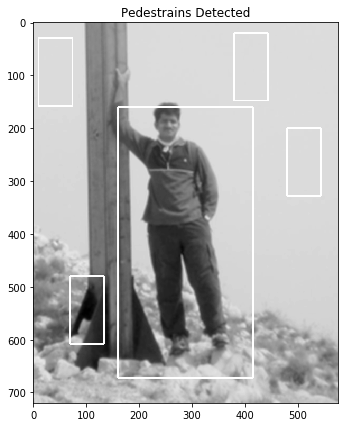

In [32]:
muestraResultado(SNoM(humanDetec,umbral = 0),fotosTest[num])